In [5]:
import numpy as np
from itertools import product
from numba import njit

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'lib')))
from decimation_staggered import (
required_initial_max_distance, right_pos_staggered,
r_max, _all_spins, plus_configs, minus_configs)
from utils import logsumexp, _xorshift64star_next, _u01_from_uint64, _rand_idx, _rand_u01


# Pool initialization: pools[d, n] = bond value at physical distance d
@njit(cache=True)
def init_pools(J0, a, D, p, N, seed=12345):
    """
    Returns:
      pools: float64 array (D+1, N), index 0 unused
      rng_state: uint64 state (carry this through for reproducibility w/o repetition)
    """
    pools = np.zeros((D + 1, N), dtype=np.float64)

    state = np.uint64(seed) ^ np.uint64(0x9E3779B97F4A7C15)
    if state == np.uint64(0):
        state = np.uint64(0xD1B54A32D192ED03)

    for d in range(1, D + 1):
        mag = J0 / (d ** a)
        for n in range(N):
            state, u = _rand_u01(state)
            sgn = -1.0 if u < p else 1.0
            pools[d, n] = sgn * mag
    return pools, state

# One quenched-disorder decimation sample for a given block separation r
@njit(cache=True)
def _intracell_energy(s, J2, J4):
    # distances inside staggered cell: 2,2,4
    s0, s1, s2 = s[0], s[1], s[2]
    return J2 * (s0 * s1 + s1 * s2) + J4 * (s0 * s2)

@njit(cache=True)
def log_Rpp_Rpm_sample_from_pools(r, pools, state):
    """
    Draws required intracell + intercell bonds from pools (with replacement),
    computes one sample of (log R_pp, log R_pm) for this r.

    pools indexed by PHYSICAL distance d.
    """
    D = pools.shape[0] - 1
    N = pools.shape[1]

    # Draw intracell couplings for left and right blocks 
    # (if D < 2 or 4, treat missing as 0)
    JL2 = 0.0
    JL4 = 0.0
    JR2 = 0.0
    JR4 = 0.0

    if D >= 2:
        state, idx = _rand_idx(state, N)
        JL2 = pools[2, idx]
        state, idx = _rand_idx(state, N)
        JR2 = pools[2, idx]
    if D >= 4:
        state, idx = _rand_idx(state, N)
        JL4 = pools[4, idx]
        state, idx = _rand_idx(state, N)
        JR4 = pools[4, idx]

    # Geometry distances between 3x3 spins
    left_pos  = np.array([1, 3, 5], dtype=np.int64)
    right_pos = right_pos_staggered(r)

    dist = np.empty((3, 3), dtype=np.int64)
    for a in range(3):
        for b in range(3):
            dist[a, b] = abs(right_pos[b] - left_pos[a])

    # --- draw intercell bond couplings for each of 9 pairs ---
    Jint = np.zeros((3, 3), dtype=np.float64)
    for a in range(3):
        for b in range(3):
            d = dist[a, b]
            if d <= D:
                state, idx = _rand_idx(state, N)
                Jint[a, b] = pools[d, idx]
            else:
                Jint[a, b] = 0.0

    # Enumerate block microstates
    n_plus = plus_configs.shape[0]   # 4
    n_minus = minus_configs.shape[0] # 4

    totals_pp = np.empty(n_plus * n_plus, dtype=np.float64)
    totals_pm = np.empty(n_plus * n_minus, dtype=np.float64)

    # R(++)
    k = 0
    for iL in range(n_plus):
        sL = plus_configs[iL]
        EL = _intracell_energy(sL, JL2, JL4)
        for iR in range(n_plus):
            sR = plus_configs[iR]
            ER = _intracell_energy(sR, JR2, JR4)
            E_int = 0.0
            for a in range(3):
                for b in range(3):
                    E_int += Jint[a, b] * sL[a] * sR[b]
            totals_pp[k] = EL + ER + E_int
            k += 1

    # R(+-)
    k = 0
    for iL in range(n_plus):
        sL = plus_configs[iL]
        EL = _intracell_energy(sL, JL2, JL4)
        for iR in range(n_minus):
            sR = minus_configs[iR]
            ER = _intracell_energy(sR, JR2, JR4)
            E_int = 0.0
            for a in range(3):
                for b in range(3):
                    E_int += Jint[a, b] * sL[a] * sR[b]
            totals_pm[k] = EL + ER + E_int
            k += 1

    log_pp = logsumexp(totals_pp)
    log_pm = logsumexp(totals_pm)
    return log_pp, log_pm, state

# RG step on pools (distributional RG / population dynamics)
@njit(cache=True)
def rg_step_pools(pools, state):
    """
    Input:
      pools: (D+1, N) pools[d, n] over physical distances d=1..D
      state: uint64 rng state (carried and advanced)

    Output:
      pools_new: (Dnew+1, N) where Dnew = r_max(D)  (reduced number of distances)
                and each pools_new[r, :] is filled with N renormalized samples
      state: updated rng state
    """
    D = pools.shape[0] - 1
    N = pools.shape[1]

    Dnew = r_max(D)
    if Dnew < 1:
        # no representable intercell separations
        return np.zeros((1, N), dtype=np.float64), state

    pools_new = np.zeros((Dnew + 1, N), dtype=np.float64)

    for r in range(1, Dnew + 1):
        for n in range(N):
            log_pp, log_pm, state = log_Rpp_Rpm_sample_from_pools(r, pools, state)
            pools_new[r, n] = 0.5 * (log_pp - log_pm)

    return pools_new, state

# RG flow (multiple steps), reproducible w/o repetition
def rg_flow_pools(J0, a, D, p, N, n_steps, seed=12345, store=True):
    """
    Returns:
      flow: list of pool matrices at each step (if store=True), otherwise final pools
    """
    pools, state = init_pools(J0, a, D, p, N, seed)
    if not store:
        for _ in range(n_steps):
            pools, state = rg_step_pools(pools, state)
        return pools

    flow = [pools.copy()]
    for _ in range(n_steps):
        pools, state = rg_step_pools(pools, state)
        flow.append(pools.copy())
    return flow

def plot_rg_flow_track_index(flow_pools, track_r=(1,2,3,4,5), pool_index=0):
    """
    flow_pools: list of arrays, each is (D_k+1, N) with index 0 unused for distance.
    track_r: iterable of distances r to track
    pool_index: fixed pool index n0 to extract at every step for each r
    """
    steps = np.arange(len(flow_pools))

    plt.figure(figsize=(7, 5))

    for r in track_r:
        vals = []
        valid_steps = []

        for k, pools in enumerate(flow_pools):
            Dk = pools.shape[0] - 1
            Nk = pools.shape[1]
            if (1 <= r <= Dk) and (0 <= pool_index < Nk):
                vals.append(pools[r, pool_index])
                valid_steps.append(k)

        if vals:
            plt.plot(np.array(valid_steps), np.array(vals), marker='o', label=f"r={r}, idx={pool_index}")

    plt.xlabel("RG step")
    plt.ylabel(r"Tracked sample $J_r^{(n_0)}$")
    plt.title("Forced index-tracked RG flow (population pools)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_pool_distributions_by_step(flow_pools, r, steps_to_plot=None, bins=40, density=True, xlim=None):
    """
    For a fixed distance r, plot histograms of pool values at multiple RG steps.

    - steps_to_plot: list/array of step indices; default: all steps
    - bins: histogram bins
    - density: normalize histogram
    - xlim: optional (xmin, xmax) shared across panels
    """
    if steps_to_plot is None:
        steps_to_plot = list(range(len(flow_pools)))

    # Filter out steps where r is out of range
    filtered = []
    for k in steps_to_plot:
        pools = flow_pools[k]
        if 1 <= r <= (pools.shape[0] - 1):
            filtered.append(k)

    if not filtered:
        raise ValueError(f"Distance r={r} not present in any requested steps.")

    n_panels = len(filtered)

    # Row of plots (as requested). If too many, you may want to switch to vertical layout.
    fig, axes = plt.subplots(
        1, n_panels,
        figsize=(3.2 * n_panels, 3.0),
        sharey=True
    )

    if n_panels == 1:
        axes = [axes]

    # Determine shared x-limits if not provided
    if xlim is None:
        all_vals = []
        for k in filtered:
            all_vals.append(flow_pools[k][r, :])
        all_vals = np.concatenate(all_vals)
        xmin, xmax = np.min(all_vals), np.max(all_vals)
        # small padding
        pad = 0.05 * (xmax - xmin + 1e-12)
        xlim = (xmin - pad, xmax + pad)

    for ax, k in zip(axes, filtered):
        vals = flow_pools[k][r, :]
        ax.hist(vals, bins=bins, density=density)
        ax.set_title(f"step {k}")
        ax.set_xlim(*xlim)
        ax.set_xlabel(r"$J_r$")

    axes[0].set_ylabel("density" if density else "count")
    fig.suptitle(f"Pool distributions across RG steps (distance r={r})", y=1.05)
    plt.tight_layout()
    plt.show()

In [12]:
J0   = 100.0
a    = 1.5
D    = 1000
p    = 0.5
N    = 1000
steps = 5
seed  = 12345

flow = rg_flow_pools(J0, a, D, p, N, steps, seed=seed, store=True)
print("Step 0 pools shape:", flow[0].shape)
for k in range(1, len(flow)):
    print(f"Step {k} pools shape:", flow[k].shape)

Step 0 pools shape: (1001, 1000)
Step 1 pools shape: (333, 1000)
Step 2 pools shape: (110, 1000)
Step 3 pools shape: (36, 1000)
Step 4 pools shape: (12, 1000)
Step 5 pools shape: (4, 1000)


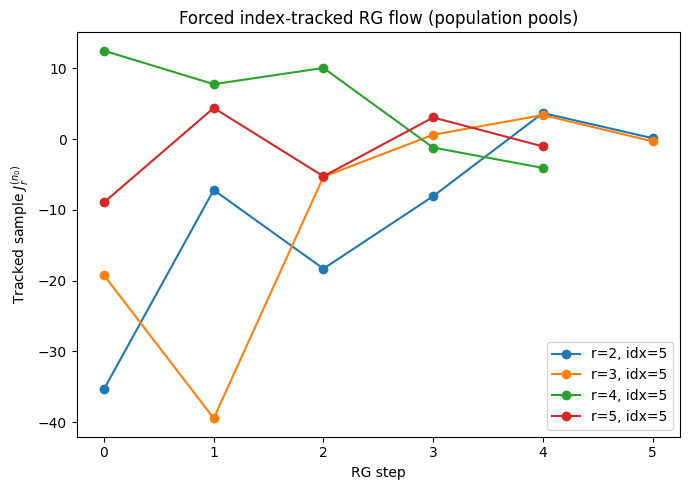

In [13]:
# 1) Track a forced index through the RG flow
plot_rg_flow_track_index(flow_pools=flow, track_r=[2,3,4,5], pool_index=5)

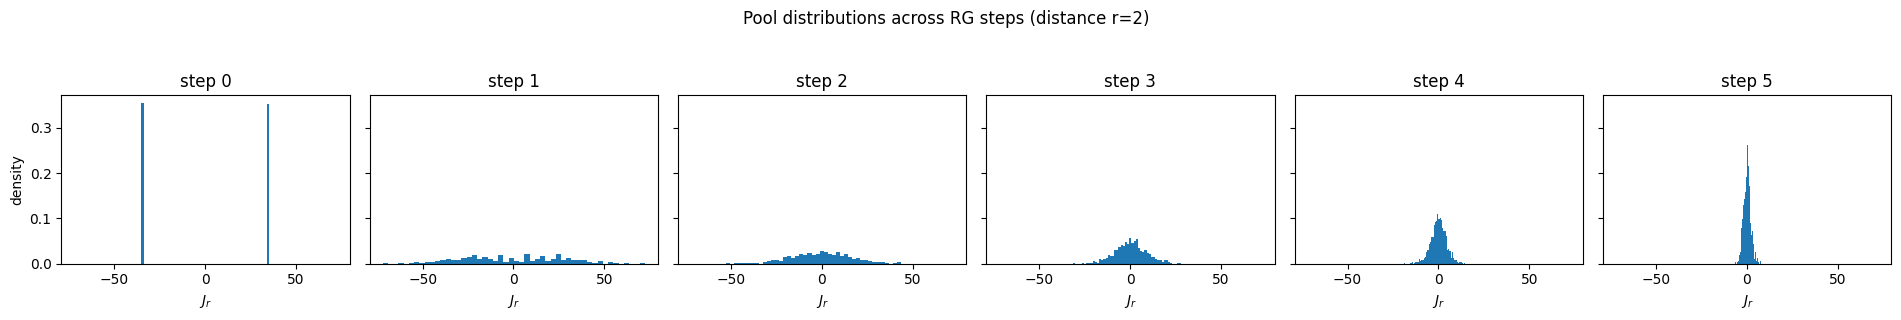

In [16]:
plot_pool_distributions_by_step(flow_pools=flow, r=2, bins=50)

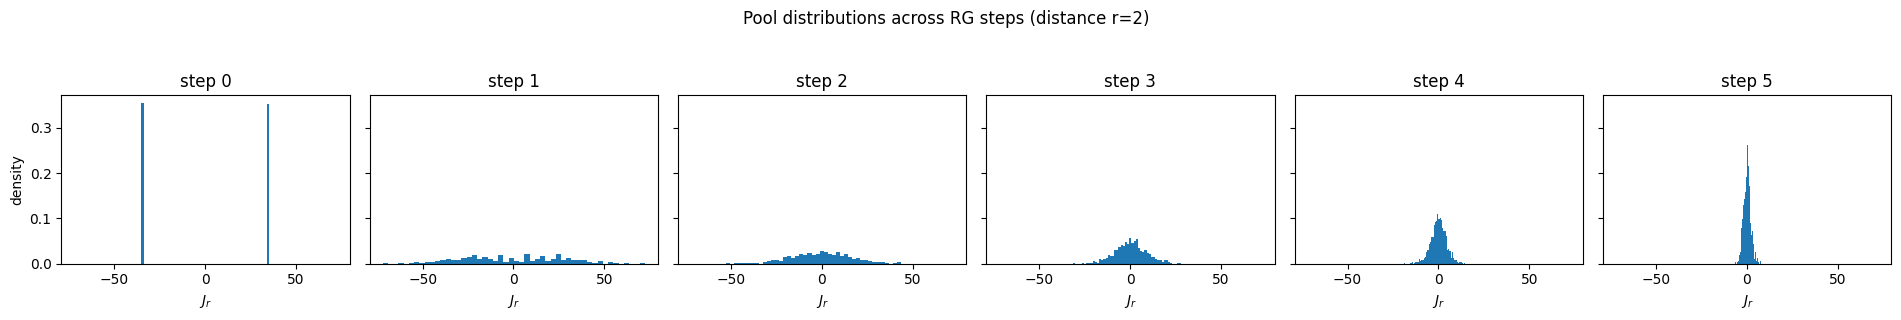

In [18]:
plot_pool_distributions_by_step(flow_pools=flow, r=2, steps_to_plot=[0,1,2,3,4,5], bins=50)